In [1]:
%reload_ext autoreload
%autoreload 2

import os
import pickle
import logging

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import scipy.stats as stats
from numpyro.diagnostics import hpdi

from hbmep.config import Config
from hbmep.nn import functional as F
from hbmep.model.utils import Site as site

from hbmep_paper.utils import setup_logging
from models import RectifiedLogistic
from core import DATA_PATH, MAT_PATH, BUILD_DIR

logger = logging.getLogger(__name__)
plt.rcParams['svg.fonttype'] = 'none'
setup_logging(dir=BUILD_DIR, fname="")


2024-03-13 14:51:45,165 - hbmep_paper.utils.utils - INFO - Logging to /home/vishu/repos/hbmep-paper/reports/figures/01_Intro/.log


In [2]:
dest = os.path.join(BUILD_DIR, "rectified_logistic", "inference.pkl")
with open(dest, "rb") as f:
    model, mcmc, posterior_samples, posterior_predictive = pickle.load(f)


2024-03-13 14:51:45,186 - jax._src.xla_bridge - INFO - Unable to initialize backend 'cuda': 
2024-03-13 14:51:45,187 - jax._src.xla_bridge - INFO - Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2024-03-13 14:51:45,187 - jax._src.xla_bridge - INFO - Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory


In [3]:
df = pd.read_csv(DATA_PATH)
mat = np.load(MAT_PATH)
df, encoder_dict = model.load(df=df)
prediction_df = pd.read_csv(os.path.join(model.build_dir, "prediction_df.csv"))


2024-03-13 14:51:45,563 - hbmep.dataset.core - INFO - Artefacts will be stored here - /home/vishu/repos/hbmep-paper/reports/figures/01_Intro/rectified_logistic
2024-03-13 14:51:45,565 - hbmep.dataset.core - INFO - Processing data ...
2024-03-13 14:51:45,566 - hbmep.utils.utils - INFO - func:load took: 0.00 sec


In [4]:
obs = posterior_predictive[site.obs]
obs_hpdi = hpdi(obs, prob=.95)
obs_map = obs.mean(axis=0)
logger.info(f"obs: {obs.shape}")
logger.info(f"obs_hpdi: {obs_hpdi.shape}")
logger.info(f"obs_map: {obs_map.shape}")

a = posterior_samples[site.a]
a_map = a.mean(axis=0)
logger.info(f"a: {a.shape}")
logger.info(f"a_map: {a_map.shape}")

H = posterior_samples[site.H]
H_map = H.mean(axis=0)
logger.info(f"H: {H.shape}")
logger.info(f"H_map: {H_map.shape}")

b = posterior_samples[site.b]
ell = posterior_samples[site.ell]
s50 = a - (1 / b) * np.log(((H + ell) / ((H / 2) + ell)) - 1)


2024-03-13 14:51:46,884 - __main__ - INFO - obs: (4000, 5000, 2)
2024-03-13 14:51:46,885 - __main__ - INFO - obs_hpdi: (2, 5000, 2)
2024-03-13 14:51:46,885 - __main__ - INFO - obs_map: (5000, 2)
2024-03-13 14:51:46,885 - __main__ - INFO - a: (4000, 1, 2)
2024-03-13 14:51:46,885 - __main__ - INFO - a_map: (1, 2)
2024-03-13 14:51:46,886 - __main__ - INFO - H: (4000, 1, 2)
2024-03-13 14:51:46,886 - __main__ - INFO - H_map: (1, 2)


In [5]:
sites = [site.a, site.b, site.L, site.ell, site.H]
params_mode = [stats.mode(posterior_samples[u], axis=0) for u in sites]
params_mode = [param.mode for param in params_mode]
params_mode = [param[0] for param in params_mode]
params = [np.mean(posterior_samples[u], axis=0) for u in sites]
params = [param[0] for param in params]


In [6]:
mep_window = [-0.01, 0.025]
mep_size_window = [0.0015, 0.01]
time = np.linspace(*mep_window, mat.shape[1])

# MEP_TIME_CONST = 1000
# MEP_CONST = [200, 100]
COLORS = [(0.8157, 0.1098, 0.5451), (0.3020, 0.6745, 0.1490)]


In [7]:
intensity, features = model._get_regressors(df=prediction_df)
intensity = intensity.reshape(-1, 1)
intensity = np.tile(intensity, (1, model.n_response))
feature0 = features[..., 0].reshape(-1,)

a, b, L, ell, H = \
    posterior_samples[site.a], \
    posterior_samples[site.b], \
    posterior_samples[site.L], \
    posterior_samples[site.ell], \
    posterior_samples[site.H]

params = [a, b, L, ell, H]
params = [u[:, feature0] for u in params]

fn_out = F.rectified_logistic(intensity, *tuple(params))
fn_out = np.array(fn_out)

fn_prime_out = F.prime(F.rectified_logistic, np.tile(intensity, (params[0].shape[0], 1, 1)), *tuple(params))
fn_prime_out = np.array(fn_prime_out)
fn_prime_out.shape


(4000, 5000, 2)

In [8]:
MEP_TIME_CONST = 1000
TIME_CONST = 1000

tick_label_size = 12
axis_label_size = 12


2024-03-13 15:43:40,560 - __main__ - INFO - Saved to /home/vishu/repos/hbmep-paper/reports/figures/01_Intro/rectified_logistic/01c_HB.png


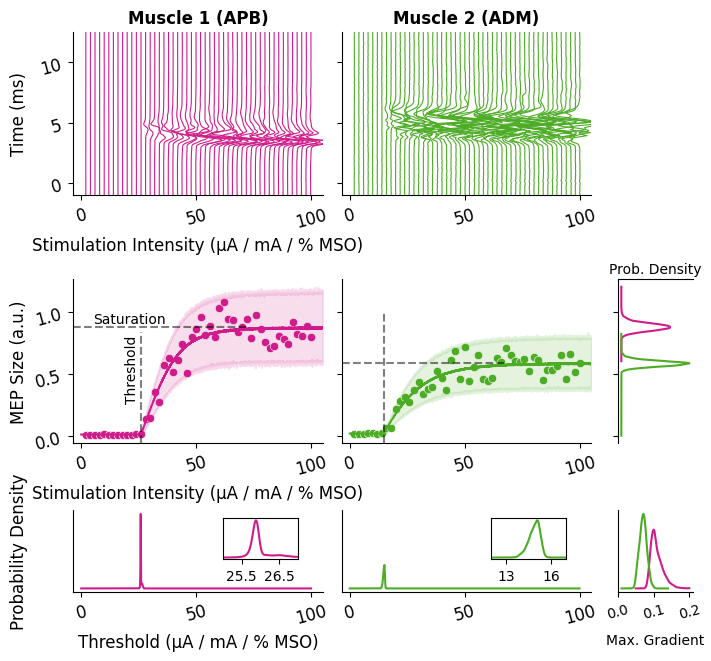

In [112]:
MEP_CONST = [250, 50]

nrows, ncols = 3, 3
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(7, 6.5), squeeze=False, constrained_layout=True, height_ratios=[1, 1, .5], width_ratios=[1, 1, .3])

for muscle_ind in [0, 1]:
    # MEP plot
    ax = axes[0, muscle_ind]
    for k in range(mat.shape[0]):
        x = mat[k, :, (muscle_ind + 1) % 2] / MEP_CONST[muscle_ind]
        x += df[model.intensity].values[k]
        ax.plot(x, time * MEP_TIME_CONST, color=COLORS[muscle_ind], linewidth=.8, alpha=1)
    ax.set_yticks(np.array([0, 0.005, 0.01]) * MEP_TIME_CONST)
    ax.set_ylim(bottom=-0.001 * MEP_TIME_CONST, top=(mep_size_window[1] + (mep_size_window[0] - (-0.001))) * MEP_TIME_CONST)

    # Recruitment curve lineplot
    ax = axes[1, muscle_ind]
    x_pred = prediction_df[model.intensity].values
    x = df[model.intensity]

    sns.lineplot(x=x_pred, y=obs.mean(axis=0)[..., muscle_ind], ax=ax, color=COLORS[muscle_ind], label="Recruitment Curve")

    # Recruitment curve scatterplot
    sns.scatterplot(x=x, y=df[model.response[muscle_ind]], color=COLORS[muscle_ind], ax=ax)

    # Recruitment curve HPDI
    ax.fill_between(
        x_pred,
        obs_hpdi[0, ..., muscle_ind],
        obs_hpdi[1, ..., muscle_ind],
        color=COLORS[muscle_ind],
        alpha=.15
    )

    if ax == axes[1, 0]:
        ax.axvline(x=a_map[0, muscle_ind], color="black", alpha=.5, linestyle="--", ymax=.68)
        # ax.axvline(x=a_map[0, muscle_ind], color="black", alpha=.5, linestyle="--", ymin=.83, ymax=1)
        ax.text((a_map[0, muscle_ind] - 1), obs_map.max(axis=0)[muscle_ind] - .06, "Threshold", rotation=90, va="top", ha="right")

    if ax == axes[1, 0]:
        ax.axhline(y=obs_map.max(axis=0)[muscle_ind], color="black", xmax=.7, alpha=.5, linestyle="--")
        ax.text((a_map[0, muscle_ind] - 5), obs_map.max(axis=0)[muscle_ind] + .01, "Saturation", va="bottom", ha="center")

    if ax == axes[1, 1]:
        ax.axvline(x=a_map[0, muscle_ind], color="black", alpha=.5, linestyle="--", ymax=.8)

    if ax == axes[1, 1]:
        ax.axhline(y=obs_map.max(axis=0)[muscle_ind], xmax=.65, color="black", alpha=.5, linestyle="--")

    # # Debuging
    # axes[1, 1].axhline(obs_map.max(axis=0)[muscle_ind])
    # axes[1, 2].axhline(obs_map.max(axis=0)[muscle_ind])

    # Threshold KDE
    ax = axes[2, muscle_ind]
    samples = a[:, 0, muscle_ind]
    samples = samples
    kde = stats.gaussian_kde(samples)
    x_grid = prediction_df[model.intensity]
    x_grid = x_grid[x_grid <= 100]
    density = kde(x_grid)
    ax.plot(x_grid, density, color=COLORS[muscle_ind])
    ins = ax.inset_axes([0.6,0.4,0.3,0.5])
    ins.plot(x_grid, density, color=COLORS[muscle_ind])
    ins.set_xlabel("")
    ins.set_ylabel("")

    if muscle_ind == 0:
        ticks = [25.5, 26.5]
        bounds = [25, 27]
        ins.set_xticks(ticks)
        ins.set_xlim(left=bounds[0], right=bounds[1])

    if muscle_ind == 1:
        ticks = [13, 16]
        bounds = [12, 17]
        ins.set_xticks(ticks)
        ins.set_xlim(left=bounds[0], right=bounds[1])

    ins.tick_params(
        axis='both',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        left=False,      # ticks along the bottom edge are off
        bottom=True,      # ticks along the bottom edge are off
        right=False,         # ticks along the top edge are off
        top=False,         # ticks along the top edge are off
        labelbottom=True,
        labelleft=False,
        labelright=False,
        labelsize=10,
        labelrotation=0
    )

    # Saturation KDE
    x_grid = np.linspace(0, 1.2, 100)
    ax = axes[1, 2]
    if muscle_ind == 0:
        samples = H[:, 0, muscle_ind] + .018
        x_grid = np.linspace(.6, 1.2, 5000)

    if muscle_ind == 1:
        samples = H[:, 0, muscle_ind] + .018
        x_grid = np.linspace(0, .82, 5000)

    kde = stats.gaussian_kde(samples)
    density = kde(x_grid)
    ax.plot(density, x_grid, color=COLORS[muscle_ind])

    # Max Gradient KDE
    ax = axes[2, 2]
    max_grad = fn_prime_out.max(axis=1)[..., muscle_ind]
    samples = max_grad
    samples = samples * 2
    kde = stats.gaussian_kde(samples)
    if muscle_ind == 0: x_grid = np.linspace(.05, .2, 1000)
    if muscle_ind == 1: x_grid = np.linspace(.01, .14, 1000)
    density = kde(x_grid)
    ax.plot(x_grid, density, color=COLORS[muscle_ind])

for i in range(nrows):
    for j in range(ncols):
        ax = axes[i, j]
        ax.set_xlabel("")
        ax.set_ylabel("")

subset = [(0, 0), (0, 1), (1, 0), (1, 1), (2, 0), (2, 1), (2, 2)]
for i, j in subset:
    ax = axes[i, j]
    sides = ['right', 'top']
    for side in sides:
        ax.spines[side].set_visible(False)
    ax.tick_params(
        axis='both',
        which='both',
        left=True,
        bottom=True,
        right=False,
        top=False,
        labelleft=False,
        labelbottom=True,
        labelright=False,
        labeltop=False,
        labelrotation=15,
        labelsize=tick_label_size
    )

subset = [(2, 0), (2, 1), (2, 2)]
for i, j in subset:
    ax = axes[i, j]
    ax.tick_params(
        axis='both',
        which='both',
        left=False,
        labelleft=False,
        rotation=15,
        labelsize=tick_label_size
    )

ax = axes[0, 2]
sides = ['left', 'top', 'right', 'bottom']
for side in sides:
    ax.spines[side].set_visible(False)
ax.tick_params(
    axis='both',
    which='both',
    left=False,
    bottom=False,
    right=False,
    top=False,
    labelleft=False,
    labelbottom=False,
    labelright=False,
    labeltop=False,
    rotation=15,
    labelsize=tick_label_size
)

ax = axes[1, 2]
sides = ['right', 'bottom']
for side in sides:
    ax.spines[side].set_visible(False)
ax.tick_params(
    axis='both',
    which='both',
    left=True,
    bottom=False,
    right=False,
    top=False,
    labelleft=False,
    labelbottom=False,
    labelright=False,
    labeltop=False,
)

##############
# Share y-axis
axes[0, 1].sharey(axes[0, 0])
axes[1, 1].sharey(axes[1, 0])
axes[1, 2].sharey(axes[1, 0])
axes[2, 1].sharey(axes[2, 0])

# Share x-axis
axes[0, 1].sharex(axes[0, 0])
axes[1, 0].sharex(axes[0, 0])
axes[1, 1].sharex(axes[0, 0])
axes[2, 0].sharex(axes[0, 0])
axes[2, 1].sharex(axes[0, 0])

# x-axis ticks
ax = axes[0, 0]
ax.set_xticks([0, 50, 100])
ax.set_yticks([0. * MEP_TIME_CONST, .005 * MEP_TIME_CONST, .01 * MEP_TIME_CONST])
ax.tick_params(axis="both", left=True, labelleft=True, labelsize=tick_label_size)

ax = axes[1, 0]
axes[1, 0].set_yticks([0., .500, 1])
ax.tick_params(axis="both", left=True, labelleft=True, labelsize=tick_label_size)
if ax.get_legend(): ax.get_legend().remove()

ax = axes[1, 1]
if ax.get_legend(): ax.get_legend().remove()

ax = axes[2, 2]
ax.set_xticks([0., .1, .2])
ax.tick_params(axis="x", labelsize=tick_label_size - 2)
ax.set_xlabel("Max. Gradient", size=axis_label_size - 2)

# Axes labels
axes[0, 0].set_ylabel("Time (ms)", size=axis_label_size)
axes[1, 0].set_ylabel("MEP Size (a.u.)", size=axis_label_size)
axes[0, 0].set_xlabel("Stimulation Intensity (µA / mA / % MSO)", size=axis_label_size)
axes[1, 0].set_xlabel("Stimulation Intensity (µA / mA / % MSO)", size=axis_label_size)
axes[2, 0].set_xlabel("Threshold (µA / mA / % MSO)", size=axis_label_size)
axes[2, 0].set_ylabel("Probability Density", size=axis_label_size)

ax = axes[1, 2]
ax.set_xlabel("Prob. Density", size=axis_label_size - 2)
ax.xaxis.set_label_position('top')

axes[0, 0].set_title("Muscle 1 (APB)", fontweight="bold")
axes[0, 1].set_title("Muscle 2 (ADM)", fontweight="bold")

ax = axes[0, 0]
ax.set_xlim(right=105)

fig.align_xlabels()
fig.align_ylabels()
fig.align_labels()

dest = os.path.join(model.build_dir, "01c_HB.svg")
fig.savefig(dest, dpi=600)

dest = os.path.join(model.build_dir, "01c_HB.png")
fig.savefig(dest, dpi=600)

logger.info(f"Saved to {dest}")


In [11]:
src = "/home/vishu/repos/hbmep-paper/reports/figures/01_Intro/nelder_mead/minimize_result.pkl"
with open(src, "rb") as f:
    nm_minimize_results, = pickle.load(f)

src = "/home/vishu/repos/hbmep-paper/reports/figures/01_Intro/best_pest/minimize_result.pkl"
with open(src, "rb") as f:
    pest_minimize_results, = pickle.load(f)

for response in model.response:
    df[response + "_bin"] = df[response].apply(lambda x: 1 if x > BINARIZE_THRESHOLD else 0)


In [74]:
src = "/home/vishu/repos/hbmep-paper/reports/figures/01_Intro/nelder_mead/params.pkl"
with open(src, "rb") as f:
    params, = pickle.load(f)


In [83]:
params[site.a]


array([[35.95266258, 26.18646643]])

In [157]:
import jax

max_grad = []
x_pred = prediction_df[model.intensity].values
for muscle_ind in range(model.n_response):
    grad = []
    for val in x_pred:
        grad.append(
            jax.grad(F.logistic4, argnums=0)(val, params[site.a][0][muscle_ind], params[site.b][0][muscle_ind], params[site.L][0][muscle_ind], params[site.H][0][muscle_ind])
        )
        # l4 = F.logistic4(val, params[site.a][0][muscle_ind], params[site.b][0][muscle_ind], params[site.L][0][muscle_ind], params[site.H][0][muscle_ind])
        # grad.append(l4 * (1 - l4))
    grad = np.array(grad)
    max_grad.append(grad.max())

In [159]:
jax.grad(F.logistic4, argnums=0)(params[site.a][0][muscle_ind], params[site.a][0][muscle_ind], params[site.b][0][muscle_ind], params[site.L][0][muscle_ind], params[site.H][0][muscle_ind]) * 2

Array(0.04259971, dtype=float64)

In [164]:
muscle_ind = 0
jax.grad(F.logistic4, argnums=0)(params[site.a][0][muscle_ind], params[site.a][0][muscle_ind], params[site.b][0][muscle_ind], params[site.L][0][muscle_ind], params[site.H][0][muscle_ind]) * 2

Array(0.02129986, dtype=float64)

In [158]:
max_grad

[0.045278776550966786, 0.021299851283241876]

2024-03-13 16:11:28,887 - __main__ - INFO - Saved to /home/vishu/repos/hbmep-paper/reports/figures/01_Intro/rectified_logistic/01b_HB.png


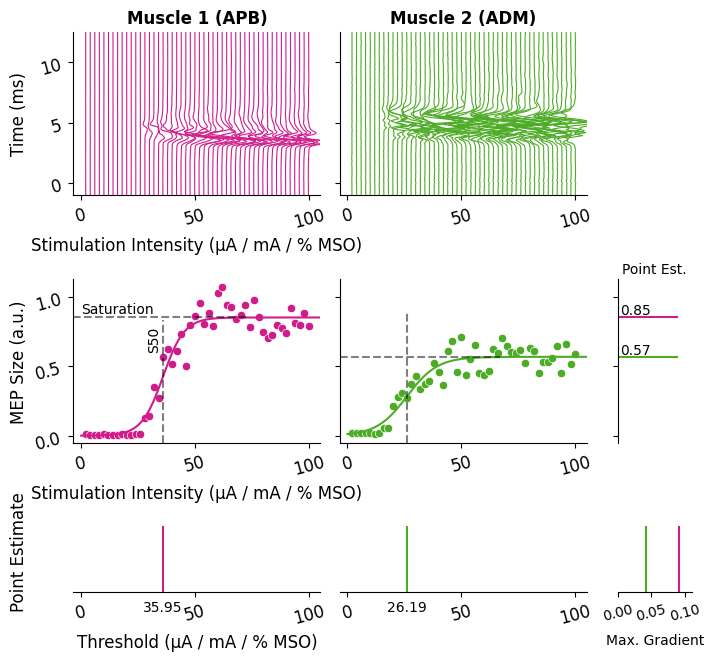

In [172]:
MEP_CONST = [250, 50]

nrows, ncols = 3, 3
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(7, 6.5), squeeze=False, constrained_layout=True, height_ratios=[1, 1, .5], width_ratios=[1, 1, .3])

for muscle_ind in [0, 1]:
    # MEP plot
    ax = axes[0, muscle_ind]
    for k in range(mat.shape[0]):
        x = mat[k, :, (muscle_ind + 1) % 2] / MEP_CONST[muscle_ind]
        x += df[model.intensity].values[k]
        ax.plot(x, time * MEP_TIME_CONST, color=COLORS[muscle_ind], linewidth=.8, alpha=1)
    ax.set_yticks(np.array([0, 0.005, 0.01]) * MEP_TIME_CONST)
    ax.set_ylim(bottom=-0.001 * MEP_TIME_CONST, top=(mep_size_window[1] + (mep_size_window[0] - (-0.001))) * MEP_TIME_CONST)

    # Recruitment curve lineplot
    ax = axes[1, muscle_ind]
    x_pred = prediction_df[model.intensity].values
    x = df[model.intensity]

    # sns.lineplot(x=x_pred, y=obs.mean(axis=0)[..., muscle_ind], ax=ax, color=COLORS[muscle_ind], label="Recruitment Curve")
    sns.lineplot(
        x=x_pred,
        y=F.logistic4(x_pred, params[site.a][0][muscle_ind], params[site.b][0][muscle_ind], params[site.L][0][muscle_ind], params[site.H][0][muscle_ind]),
        ax=ax,
        color=COLORS[muscle_ind],
        label="Recruitment Curve"
    )

    # Recruitment curve scatterplot
    sns.scatterplot(x=x, y=df[model.response[muscle_ind]], color=COLORS[muscle_ind], ax=ax)

    if ax == axes[1, 0]:
        ax.axvline(x=params[site.a][0][muscle_ind], color="black", alpha=.5, linestyle="--", ymax=.75)
        # ax.axvline(x=a_map[0, muscle_ind], color="black", alpha=.5, linestyle="--", ymin=.83, ymax=1)
        ax.text((params[site.a][0][muscle_ind] - 1), params[site.H][0][muscle_ind] - .06, "S50", rotation=90, va="top", ha="right")

    if ax == axes[1, 0]:
        ax.axhline(y=params[site.H][0][muscle_ind], color="black", xmax=.7, alpha=.5, linestyle="--")
        ax.text((params[site.a][0][muscle_ind] - 20), params[site.H][0][muscle_ind] + .01, "Saturation", va="bottom", ha="center")

    if ax == axes[1, 1]:
        ax.axvline(x=params[site.a][0][muscle_ind], color="black", alpha=.5, linestyle="--", ymax=.8)

    if ax == axes[1, 1]:
        ax.axhline(y=params[site.H][0][muscle_ind], xmax=.65, color="black", alpha=.5, linestyle="--")

#     # # Debuging
#     # axes[1, 1].axhline(obs_map.max(axis=0)[muscle_ind])
#     # axes[1, 2].axhline(obs_map.max(axis=0)[muscle_ind])

    # Threshold KDE
    ax = axes[2, muscle_ind]
    ax.axvline(params[site.a][0][muscle_ind], color=COLORS[muscle_ind], ymax=.8)

    # Saturation KDE
    ax = axes[1, 2]
    ax.axhline(params[site.H][0][muscle_ind], color=COLORS[muscle_ind], xmax=.8)

    # Max Gradient KDE
    ax = axes[2, 2]
    # ax.axvline(max_grad[muscle_ind], color=COLORS[muscle_ind], ymax=.8)
    ax.axvline(
        jax.grad(F.logistic4, argnums=0)(params[site.a][0][muscle_ind], params[site.a][0][muscle_ind], params[site.b][0][muscle_ind], params[site.L][0][muscle_ind], params[site.H][0][muscle_ind]) * 2,
        color=COLORS[muscle_ind],
        ymax=.8
    )

for i in range(nrows):
    for j in range(ncols):
        ax = axes[i, j]
        ax.set_xlabel("")
        ax.set_ylabel("")

subset = [(0, 0), (0, 1), (1, 0), (1, 1), (2, 0), (2, 1), (2, 2)]
for i, j in subset:
    ax = axes[i, j]
    sides = ['right', 'top']
    for side in sides:
        ax.spines[side].set_visible(False)
    ax.tick_params(
        axis='both',
        which='both',
        left=True,
        bottom=True,
        right=False,
        top=False,
        labelleft=False,
        labelbottom=True,
        labelright=False,
        labeltop=False,
        labelrotation=15,
        labelsize=tick_label_size
    )

subset = [(2, 0), (2, 1), (2, 2)]
for i, j in subset:
    ax = axes[i, j]
    ax.tick_params(
        axis='both',
        which='both',
        left=False,
        labelleft=False,
        rotation=15,
        labelsize=tick_label_size
    )

ax = axes[0, 2]
sides = ['left', 'top', 'right', 'bottom']
for side in sides:
    ax.spines[side].set_visible(False)
ax.tick_params(
    axis='both',
    which='both',
    left=False,
    bottom=False,
    right=False,
    top=False,
    labelleft=False,
    labelbottom=False,
    labelright=False,
    labeltop=False,
    rotation=15,
    labelsize=tick_label_size
)

ax = axes[1, 2]
sides = ['right', 'bottom']
for side in sides:
    ax.spines[side].set_visible(False)
ax.tick_params(
    axis='both',
    which='both',
    left=True,
    bottom=False,
    right=False,
    top=False,
    labelleft=False,
    labelbottom=False,
    labelright=False,
    labeltop=False,
)

##############
# Share y-axis
axes[0, 1].sharey(axes[0, 0])
axes[1, 1].sharey(axes[1, 0])
axes[1, 2].sharey(axes[1, 0])
axes[2, 1].sharey(axes[2, 0])

# Share x-axis
axes[0, 1].sharex(axes[0, 0])
axes[1, 0].sharex(axes[0, 0])
axes[1, 1].sharex(axes[0, 0])
axes[2, 0].sharex(axes[0, 0])
axes[2, 1].sharex(axes[0, 0])

# x-axis ticks
ax = axes[0, 0]
ax.set_xticks([0, 50, 100])
ax.set_yticks([0. * MEP_TIME_CONST, .005 * MEP_TIME_CONST, .01 * MEP_TIME_CONST])
ax.tick_params(axis="both", left=True, labelleft=True, labelsize=tick_label_size)

ax = axes[1, 0]
axes[1, 0].set_yticks([0., .500, 1])
ax.tick_params(axis="both", left=True, labelleft=True, labelsize=tick_label_size)
if ax.get_legend(): ax.get_legend().remove()

ax = axes[1, 1]
if ax.get_legend(): ax.get_legend().remove()

ax = axes[2, 2]
# ax.set_xticks([0., .1, .2])
ax.tick_params(axis="x", labelsize=tick_label_size - 2)
ax.set_xlabel("Max. Gradient", size=axis_label_size - 2)

# Axes labels
axes[0, 0].set_ylabel("Time (ms)", size=axis_label_size)
axes[1, 0].set_ylabel("MEP Size (a.u.)", size=axis_label_size)
axes[0, 0].set_xlabel("Stimulation Intensity (µA / mA / % MSO)", size=axis_label_size)
axes[1, 0].set_xlabel("Stimulation Intensity (µA / mA / % MSO)", size=axis_label_size)
axes[2, 0].set_xlabel("Threshold (µA / mA / % MSO)", size=axis_label_size)
axes[2, 0].set_ylabel("Point Estimate", size=axis_label_size)

ax = axes[1, 2]
ax.set_xlabel("Point Est.", size=axis_label_size - 2)
ax.xaxis.set_label_position('top')

axes[0, 0].set_title("Muscle 1 (APB)", fontweight="bold")
axes[0, 1].set_title("Muscle 2 (ADM)", fontweight="bold")

ax = axes[0, 0]
ax.set_xlim(right=105)

for muscle_ind in range(model.n_response):
    ax = axes[2, muscle_ind]
    ax.text(params[site.a][0][muscle_ind], -.1, f"{params[site.a][0][muscle_ind]:.2f}", ha="center", va="top", fontsize=10)
    sides = ['left']
    for side in sides:
        ax.spines[side].set_visible(False)
    ax = axes[1, 2]
    ax.text(.45, params[site.H][0][muscle_ind] + .05, f"{params[site.H][0][muscle_ind]:.2f}", ha="right", va="center", fontsize=10)
    sides = ['top']
    for side in sides:
        ax.spines[side].set_visible(False)
    ax = axes[2, 2]
    sides = ['left']
    for side in sides:
        ax.spines[side].set_visible(False)

ax = axes[2, 2]
ax.set_xlim(right=.11)
ax.set_xticks([0., .05, .1])
# ax.set_xticks(max_grad)

fig.align_xlabels()
fig.align_ylabels()
fig.align_labels()

dest = os.path.join(model.build_dir, "01b_HB.svg")
fig.savefig(dest, dpi=600)

dest = os.path.join(model.build_dir, "01b_HB.png")
fig.savefig(dest, dpi=600)

logger.info(f"Saved to {dest}")


In [92]:
H_grid = np.linspace(0, 1.05, 5000)
H_density = []
for muscle_ind in [0, 1]:
    samples = H[:, 0, muscle_ind]
    kde = stats.gaussian_kde(samples)
    density = kde(H_grid)
    H_density.append(density)


In [13]:
a_grid = np.linspace(0, 100, 5000)
a_density = []
for muscle_ind in [0, 1]:
    samples = a[:, 0, muscle_ind] / 2
    kde = stats.gaussian_kde(samples)
    density = kde(a_grid)
    a_density.append(density)


In [62]:
grad_grid = np.linspace(0, .06, 5000)
grad_density = []
for muscle_ind in [0, 1]:
    samples = fn_prime_out.max(axis=1)[..., muscle_ind]
    samples = samples * 2
    kde = stats.gaussian_kde(samples)
    density = kde(grad_grid)
    grad_density.append(density)


In [54]:
import jax

2024-02-06 09:19:53,574 - __main__ - INFO - Saved to /home/vishu/repos/hbmep-paper/reports/figures/01_Intro/01_introduction.png


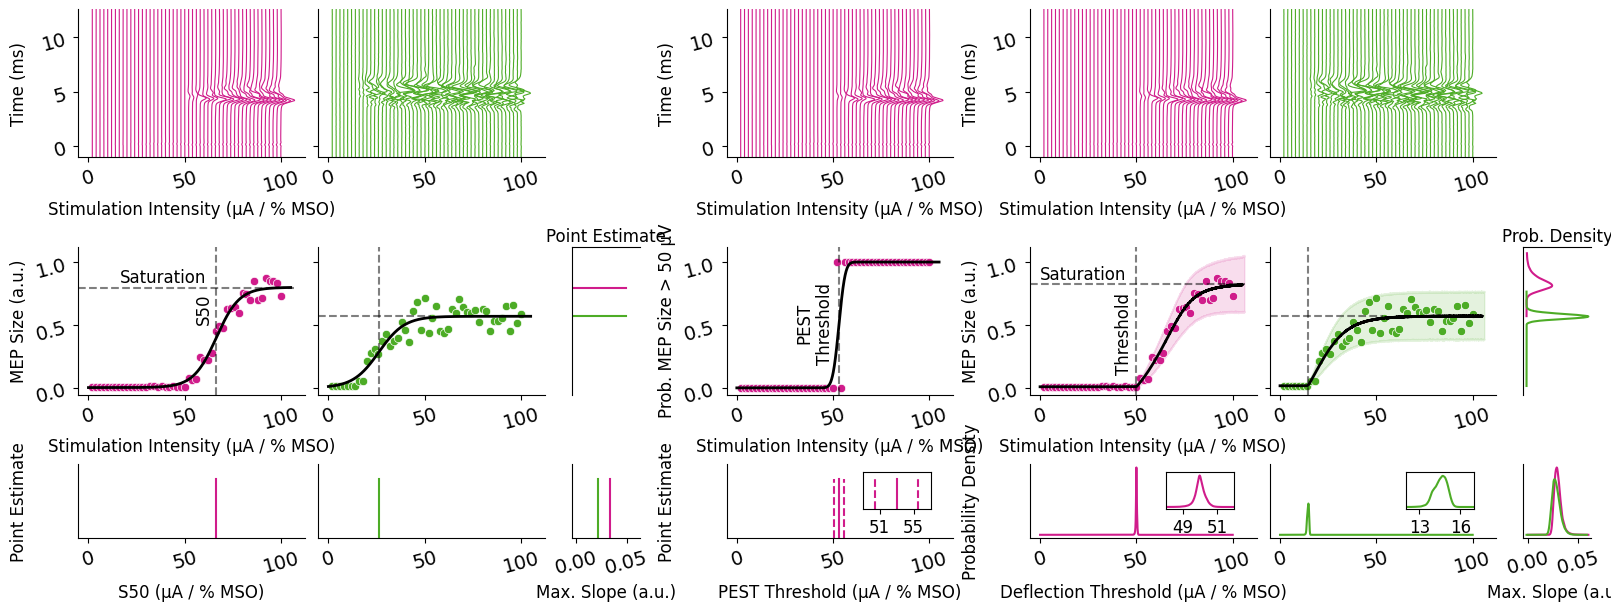

In [304]:
MEP_CONST = [150, 50]

tick_label_size = 14
axis_label_size = 12
inset_size = 12
inset_rotation = 0

def turn_off(ax):
    sides = ['right', 'top', 'left', 'bottom']
    for side in sides:
        ax.spines[side].set_visible(False)
    ax.tick_params(
        axis="both",
        left=False,
        right=False,
        top=False,
        bottom=False,
        labelleft=False,
        labelright=False,
        labeltop=False,
        labelbottom=False
    )
    return


def mep_plot(ax, muscle_ind):
    for k in range(mat.shape[0]):
        x = mat[k, :, muscle_ind] / MEP_CONST[muscle_ind]
        x += df[model.intensity].values[k]
        x = x / 2
        ax.plot(x, time * MEP_TIME_CONST, color=COLORS[muscle_ind], linewidth=.8, alpha=1)
    ax.set_yticks(np.array([0, 0.005, 0.01]) * MEP_TIME_CONST)
    ax.set_ylim(bottom=-0.001 * MEP_TIME_CONST, top=(mep_size_window[1] + (mep_size_window[0] - (-0.001))) * MEP_TIME_CONST)


def curve_plot(ax, x, y, x_pred, y_pred, muscle_ind):
    x_pred = prediction_df[model.intensity].values
    x = df[model.intensity]
    x_pred = x_pred / 2
    x = x / 2

    # sns.lineplot(x=x_pred, y=y_pred, ax=ax, color=COLORS[muscle_ind], label="Recruitment Curve")
    sns.lineplot(x=x_pred[x_pred < 105], y=y_pred[x_pred < 105], ax=ax, color="k", linewidth=2, label="Recruitment Curve")
    # ax.plot(x_pred, y_pred, color="k", linestyle="--", linewidth=2)

    sns.scatterplot(x=x, y=y, color=COLORS[muscle_ind], ax=ax)
    if ax.get_legend(): ax.get_legend().remove()
    return


def observational_hpdi(ax, x, muscle_ind):
    ax.fill_between(
        x[x < 106],
        obs_hpdi[0, ..., muscle_ind][x < 106],
        obs_hpdi[1, ..., muscle_ind][x < 106],
        color=COLORS[muscle_ind],
        alpha=.15
    )
    return


nrows, ncols = 3, 7
fig, axes = plt.subplots(
    nrows=nrows,
    ncols=ncols,
    figsize=(16, 6),
    squeeze=False,
    constrained_layout=True,
    height_ratios=[1, 1, .5],
    width_ratios=[1, 1, .3, 1., 1, 1, .3],
)

mep_plot(axes[0, 0], 0)
mep_plot(axes[0, 1], 1)
mep_plot(axes[0, 3], 0)
mep_plot(axes[0, 4], 0)
mep_plot(axes[0, 5], 1)

x = df[model.intensity]
x_pred = prediction_df[model.intensity].values

muscle_ind = 0
y = df[model.response[muscle_ind]]

res_x = nm_minimize_results[muscle_ind].x
y_pred = F.logistic4(prediction_df[model.intensity].values, *res_x)
ax = axes[1, 0]
curve_plot(ax, x / 2, y, x_pred / 2, y_pred, muscle_ind)
ax = axes[1, 3]
res_x = pest_minimize_results[muscle_ind].x
y_pred = stats.norm.cdf(prediction_df[model.intensity].values, *res_x)
curve_plot(ax, x / 2, df[model.response[muscle_ind] + "_bin"], x_pred / 2, y_pred, muscle_ind)

y_pred = obs[:, :, muscle_ind].mean(axis=0)
ax = axes[1, 4]
observational_hpdi(ax, x_pred / 2, muscle_ind)
curve_plot(ax, x / 2, y, x_pred / 2, y_pred, muscle_ind)

muscle_ind = 1
y = df[model.response[muscle_ind]]

res_x = nm_minimize_results[muscle_ind].x
y_pred = F.logistic4(prediction_df[model.intensity].values, *res_x)
ax = axes[1, 1]
curve_plot(ax, x / 2, y, x_pred / 2, y_pred, muscle_ind)

y_pred = obs[:, :, muscle_ind].mean(axis=0)
ax = axes[1, 5]
observational_hpdi(ax, x_pred / 2, muscle_ind)
curve_plot(ax, x / 2, y, x_pred / 2, y_pred, muscle_ind)

# Saturation Point Estimate
ax = axes[1, 2]
muscle_ind = 0
res_x = nm_minimize_results[muscle_ind].x
ax.axhline(res_x[-1], color=COLORS[muscle_ind], xmax=.8)
muscle_ind = 1
res_x = nm_minimize_results[muscle_ind].x
ax.axhline(res_x[-1], color=COLORS[muscle_ind], xmax=.8)

# Saturation KDE
ax = axes[1, 6]
muscle_ind = 0
ax.plot(H_density[muscle_ind][H_grid > .55], H_grid[H_grid > .55] + .02, color=COLORS[muscle_ind])
muscle_ind = 1
ax.plot(H_density[muscle_ind][H_grid < .75], H_grid[H_grid < .75] + .015, color=COLORS[muscle_ind])

# # Debugging
# muscle_ind = 0
# ax = axes[1, 5]
# ax.axhline(obs[:, :, muscle_ind].mean(axis=0).max(), color="r", linewidth=1)
# ax = axes[1, 6]
# ax.axhline(obs[:, :, muscle_ind].mean(axis=0).max(), color="r", linewidth=1)
# muscle_ind = 1
# ax = axes[1, 5]
# ax.axhline(obs[:, :, muscle_ind].mean(axis=0).max(), color="r", linewidth=1)
# ax = axes[1, 6]
# ax.axhline(obs[:, :, muscle_ind].mean(axis=0).max(), color="r", linewidth=1)

# Threshold Point Estimate
muscle_ind = 0
res_x = nm_minimize_results[muscle_ind].x
ax = axes[2, 0]
ax.axvline(res_x[0] / 2, color=COLORS[muscle_ind], ymax=.8)
muscle_ind = 1
res_x = nm_minimize_results[muscle_ind].x
ax = axes[2, 1]
ax.axvline(res_x[0] / 2, color=COLORS[muscle_ind], ymax=.8)

muscle_ind = 0
res_x = pest_minimize_results[muscle_ind].x
ax = axes[2, 3]
ax.axvline(res_x[0] / 2, color=COLORS[muscle_ind], ymax=.8)
quantile_84 = stats.norm.ppf(.84, loc=res_x[0], scale=res_x[1])
ax.axvline(quantile_84 / 2, color=COLORS[muscle_ind], linestyle="--", ymax=.8)
ax.axvline((res_x[0] - (quantile_84 - res_x[0])) / 2, color=COLORS[muscle_ind], linestyle="--", ymax=.8)
ins = ax.inset_axes([0.6,0.4,0.3,0.5])
ins.axvline(res_x[0] / 2, color=COLORS[muscle_ind], ymax=.8)
ins.axvline(quantile_84 / 2, color=COLORS[muscle_ind], linestyle="--", ymax=.8)
ins.axvline((res_x[0] - (quantile_84 - res_x[0])) / 2, color=COLORS[muscle_ind], linestyle="--", ymax=.8)
ins.set_xlabel("")
ins.set_ylabel("")
ins.set_xlim(left=49, right=57)
ins.set_xticks([51, 55])
ins.tick_params(
    axis='both',
    which='both',
    left=False,
    bottom=True,
    right=False,
    top=False,
    labelbottom=True,
    labelleft=False,
    labelright=False,
    labeltop=False,
    labelsize=inset_size,
    labelrotation=inset_rotation
)


# Threshold KDE
ax = axes[2, 4]
muscle_ind = 0
ax.plot(a_grid, a_density[muscle_ind], color=COLORS[muscle_ind])
ins = ax.inset_axes([0.6,0.4,0.3,0.5])
ins.plot(a_grid, a_density[muscle_ind], color=COLORS[muscle_ind])
ins.set_xlabel("")
ins.set_ylabel("")
ins.set_xlim(left=48, right=52)
ins.set_xticks([49, 51])
ins.tick_params(
    axis='both',
    which='both',
    left=False,
    bottom=True,
    right=False,
    top=False,
    labelbottom=True,
    labelleft=False,
    labelright=False,
    labeltop=False,
    labelsize=inset_size,
    labelrotation=inset_rotation
)
ins.set_ylim(top=2)

ax = axes[2, 5]
muscle_ind = 1
ax.plot(a_grid, a_density[muscle_ind], color=COLORS[muscle_ind])
ins = ax.inset_axes([0.6,0.4,0.3,0.5])
ins.plot(a_grid, a_density[muscle_ind], color=COLORS[muscle_ind])
ins.set_xlabel("")
ins.set_ylabel("")
ins.set_xlim(left=12, right=17)
ins.set_xticks([13, 16])
ins.tick_params(
    axis='both',
    which='both',
    left=False,
    bottom=True,
    right=False,
    top=False,
    labelbottom=True,
    labelleft=False,
    labelright=False,
    labeltop=False,
    labelsize=inset_size,
    labelrotation=inset_rotation
)
ins.set_ylim(top=.94)

# Max. Gradient Point Estimate
ax = axes[2, 2]
muscle_ind = 0
res_x = nm_minimize_results[muscle_ind].x
ax.axvline(jax.grad(F.logistic4)(res_x[0], *res_x).item() * 2, color=COLORS[muscle_ind], ymax=.8)
muscle_ind = 1
res_x = nm_minimize_results[muscle_ind].x
ax.axvline(jax.grad(F.logistic4)(res_x[0], *res_x).item() * 2, color=COLORS[muscle_ind], ymax=.8)
ax.set_xlim(left=0, right=0.06)

# Max. Gradient KDE
ax = axes[2, 6]
muscle_ind = 0
ax.plot(grad_grid, grad_density[muscle_ind], color=COLORS[muscle_ind])
muscle_ind = 1
ax.plot(grad_grid - .0015, grad_density[muscle_ind], color=COLORS[muscle_ind])

for i in range(nrows):
    for j in range(ncols):
        ax = axes[i, j]
        ax.set_xlabel("")
        ax.set_ylabel("")
        ax.tick_params(
            axis='both',
            which='both',
            left=True,
            bottom=True,
            right=False,
            top=False,
            labelleft=True,
            labelbottom=True,
            labelright=False,
            labeltop=False,
            labelsize=tick_label_size,
            labelrotation=15
        )
        for sides in ['right', 'top']:
            ax.spines[sides].set_visible(False)

turn_off(axes[0, 2])
turn_off(axes[0, 6])
for j in [1, 2, 5, 6]:
    ax = axes[0, j]
    ax.tick_params(axis="y", labelleft=False)
    ax = axes[1, j]
    ax.tick_params(axis="y", labelleft=False)
for j in range(ncols):
    ax = axes[2, j]
    ax.tick_params(axis="y", left=False, labelleft=False)

for j in [2, 6]:
    ax = axes[1, j]
    ax.spines["bottom"].set_visible(False)
    ax.spines["top"].set_visible(True)
    ax.tick_params(axis="both", which="both", left=False, bottom=False, labelbottom=False)

# Share x-axis
for j in [0, 1, 3, 4, 5]:
    axes[0, j].sharex(axes[0, 0])
    axes[1, j].sharex(axes[0, 0])
    axes[2, j].sharex(axes[0, 0])

axes[2, 2].sharex(axes[2, 6])

# Share y-axis
for j in range(ncols):
    axes[1, j].sharey(axes[1, 0])

axes[2, 1].sharey(axes[2, 0])
axes[2, 3].sharey(axes[2, 0])
axes[2, 5].sharey(axes[2, 4])

# x-axis ticks
ax = axes[0, 0]
ax.set_xticks([0, 50, 100])

ax = axes[2, 2]
ax.set_xticks([0, .05])

# y-axis ticks
ax = axes[0, 0]
ax.set_yticks([0, 5, 10])
ax = axes[1, 0]
ax.set_yticks([0, 0.5, 1])

# x-axis labels
for j in [0, 3, 4]:
    ax = axes[0, j]
    ax.set_xlabel("Stimulation Intensity (µA / % MSO)", size=axis_label_size)
    ax = axes[1, j]
    ax.set_xlabel("Stimulation Intensity (µA / % MSO)", size=axis_label_size)
    ax = axes[2, j]
    match j:
        case 0:
            xlabel = "S50 (µA / % MSO)"
        case 3:
            xlabel = "PEST Threshold (µA / % MSO)"
        case 4:
            xlabel = "Deflection Threshold (µA / % MSO)"
    ax.set_xlabel(xlabel, size=axis_label_size)

ax = axes[2, 2]
ax.set_xlabel("Max. Slope (a.u.)", size=axis_label_size)
ax = axes[2, 6]
ax.set_xlabel("Max. Slope (a.u.)", size=axis_label_size)

# y-axis labels
for j in [0, 3, 4]:
    ax = axes[0, j]
    ax.set_ylabel("Time (ms)", size=axis_label_size)
    ax = axes[1, j]
    if j == 3:
        label = "Prob. MEP Size > 50 µV"
    else:
        label = "MEP Size (a.u.)"
    ax.set_ylabel(label, size=axis_label_size)

for j in [0, 3]:
    ax = axes[2, j]
    ax.set_ylabel("Point Estimate", size=axis_label_size)


ax = axes[1, 2]
ax.set_xlabel("Point Estimate", size=axis_label_size)
ax.xaxis.set_label_position('top')

ax = axes[1, 6]
ax.set_xlabel("Prob. Density", size=axis_label_size)
ax.xaxis.set_label_position('top')

ax = axes[2, 4]
ax.set_ylabel("Probability Density", size=axis_label_size)

ax = axes[1, 0]
muscle_ind = 0
res_x = nm_minimize_results[muscle_ind].x
ax.axvline(x=res_x[0] / 2, color="black", alpha=.5, linestyle="--")
ax.text((res_x[0] - 4) / 2, res_x[-1] - .04, "S50", rotation=90, va="top", ha="right", fontsize=inset_size)
ax.axhline(y=res_x[-1], color="black", xmax=.95, alpha=.5, linestyle="--")
ax.text((res_x[0] - 55) / 2, res_x[-1] + .01, "Saturation", va="bottom", ha="center", fontsize=inset_size)

ax = axes[1, 1]
muscle_ind = 1
res_x = nm_minimize_results[muscle_ind].x
ax.axvline(x=res_x[0] / 2, color="black", alpha=.5, linestyle="--")
# ax.text((res_x[0] - 2) / 2, res_x[-1] - .04, "S50", rotation=90, va="top", ha="right")
ax.axhline(y=res_x[-1], color="black", xmax=.5, alpha=.5, linestyle="--")
# ax.text((res_x[0] - 45) / 2, res_x[-1] + .01, "Saturation", va="bottom", ha="center")

ax = axes[1, 3]
muscle_ind = 0
res_x = pest_minimize_results[muscle_ind].x
ax.axvline(x=res_x[0] / 2, color="black", alpha=.5, linestyle="--")
ax.text((res_x[0] - 25) / 2, .84, "PEST\nThreshold", rotation=90, va="top", ha="center", fontsize=inset_size)

ax = axes[1, 4]
muscle_ind = 0
ax.axvline(x=a_map[0, muscle_ind] / 2, color="black", alpha=.5, linestyle="--")
ax.text((a_map[0, muscle_ind] - 4) / 2, obs_map.max(axis=0)[muscle_ind] - .06, "Threshold", rotation=90, va="top", ha="right", fontsize=inset_size)
ax.axhline(y=obs_map.max(axis=0)[muscle_ind], color="black", xmax=.95, alpha=.5, linestyle="--")
ax.text((a_map[0, muscle_ind] - 55) / 2, obs_map.max(axis=0)[muscle_ind] + .01, "Saturation", va="bottom", ha="center", fontsize=inset_size)

ax = axes[1, 5]
muscle_ind = 1
ax.axvline(x=a_map[0, muscle_ind] / 2, color="black", alpha=.5, linestyle="--")
# ax.text((a_map[0, muscle_ind] - 2) / 2, obs_map.max(axis=0)[muscle_ind] - .06, "Threshold", rotation=90, va="top", ha="right")
ax.axhline(y=obs_map.max(axis=0)[muscle_ind], color="black", xmax=.5, alpha=.5, linestyle="--")
# ax.text((a_map[0, muscle_ind] - 45) / 2, obs_map.max(axis=0)[muscle_ind] + .01, "Saturation", va="bottom", ha="center")

fig.align_xlabels()
fig.align_ylabels()
fig.align_labels()

dest = os.path.join(BUILD_DIR, "01_introduction.svg")
fig.savefig(dest, dpi=600)

dest = os.path.join(BUILD_DIR, "01_introduction.png")
fig.savefig(dest, dpi=600)
logger.info(f"Saved to {dest}")



In [ ]:


nrows, ncols = 3, 3
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(2.5 * ncols, 2.2 * nrows), squeeze=False, constrained_layout=True, height_ratios=[1, 1, .5], width_ratios=[1, 1, .3])

for muscle_ind in [0, 1]:
    # MEP plot
    ax = axes[0, muscle_ind]
    for k in range(mat.shape[0]):
        x = mat[k, :, muscle_ind] / MEP_CONST[muscle_ind]
        x += df[model.intensity].values[k]
        x = x / 2
        ax.plot(x, time * MEP_TIME_CONST, color=COLORS[muscle_ind], linewidth=.8, alpha=1)
    ax.set_yticks(np.array([0, 0.005, 0.01]) * MEP_TIME_CONST)
    ax.set_ylim(bottom=-0.001 * MEP_TIME_CONST, top=(mep_size_window[1] + (mep_size_window[0] - (-0.001))) * MEP_TIME_CONST)

    # Recruitment curve lineplot
    ax = axes[1, muscle_ind]
    x_pred = prediction_df[model.intensity].values
    x = df[model.intensity]
    x_pred = x_pred / 2
    x = x / 2

    sns.lineplot(x=x_pred, y=obs.mean(axis=0)[..., muscle_ind], ax=ax, color=COLORS[muscle_ind], label="Recruitment Curve")
    # sns.lineplot(x=x_pred, y=TIME_CONST * F.rectified_logistic(x_pred, *(param[muscle_ind] for param in params)), ax=ax, color=COLORS[muscle_ind], label="Recruitment Curve")

    # Recruitment curve scatterplot
    sns.scatterplot(x=x, y=df[model.response[muscle_ind]], color=COLORS[muscle_ind], ax=ax)

    # Recruitment curve HPDI
    ax.fill_between(
        x_pred,
        obs_hpdi[0, ..., muscle_ind],
        obs_hpdi[1, ..., muscle_ind],
        color=COLORS[muscle_ind],
        alpha=.15
    )

    if ax == axes[1, 0]:
        ax.axvline(x=a_map[0, muscle_ind] / 2, color="black", alpha=.5, linestyle="--")
        ax.text((a_map[0, muscle_ind] - 1) / 2, obs_map.max(axis=0)[muscle_ind] - .06, "Threshold", rotation=90, va="top", ha="right")

    if ax == axes[1, 0]:
        ax.axhline(y=obs_map.max(axis=0)[muscle_ind], color="black", xmax=.95, alpha=.5, linestyle="--")
        ax.text((a_map[0, muscle_ind] - 35) / 2, obs_map.max(axis=0)[muscle_ind] + .01, "Saturation", va="bottom", ha="center")

    if ax == axes[1, 1]:
        ax.axvline(x=a_map[0, muscle_ind] / 2, color="black", alpha=.5, linestyle="--")

    if ax == axes[1, 1]:
        ax.axhline(y=obs_map.max(axis=0)[muscle_ind], xmax=.65, color="black", alpha=.5, linestyle="--")

    # # Debuging
    # axes[1, 1].axhline(obs_map.max(axis=0)[muscle_ind])
    # axes[1, 2].axhline(obs_map.max(axis=0)[muscle_ind])

    # Threshold KDE
    ax = axes[2, muscle_ind]
    samples = a[:, 0, muscle_ind]
    samples = samples / 2
    kde = stats.gaussian_kde(samples)
    x_grid = prediction_df[model.intensity]
    x_grid = x_grid / 2
    density = kde(x_grid)
    ax.plot(x_grid, density, color=COLORS[muscle_ind])
    ins = ax.inset_axes([0.6,0.4,0.3,0.5])
    ins.plot(x_grid, density, color=COLORS[muscle_ind])
    ins.set_xlabel("")
    ins.set_ylabel("")

    if muscle_ind == 0:
        ticks = [49, 51]
        bounds = [48, 52]
        ins.set_xticks(ticks)
        ins.set_xlim(left=bounds[0], right=bounds[1])

    if muscle_ind == 1:
        ticks = [13, 16]
        bounds = [12, 17]
        ins.set_xticks(ticks)
        ins.set_xlim(left=bounds[0], right=bounds[1])

    ins.tick_params(
        axis='both',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        left=False,      # ticks along the bottom edge are off
        bottom=True,      # ticks along the bottom edge are off
        right=False,         # ticks along the top edge are off
        top=False,         # ticks along the top edge are off
        labelbottom=True,
        labelleft=False,
        labelright=False,
        labelsize=tick_label_size,
        labelrotation=10
    )

    # Saturation KDE
    ax = axes[1, 2]
    if muscle_ind == 0:
        samples = (H[:, 0, muscle_ind] * TIME_CONST) + .03
        x_grid = np.linspace(.6, 1.2, 5000)

    if muscle_ind == 1:
        samples = H[:, 0, muscle_ind] * TIME_CONST + .02
        x_grid = np.linspace(0, .75, 5000)

    kde = stats.gaussian_kde(samples)
    density = kde(x_grid)
    ax.plot(density, x_grid, color=COLORS[muscle_ind])
    ax.set_ylim(top=1.2)

    # Max Gradient KDE
    ax = axes[2, 2]
    max_grad = fn_prime_out.max(axis=1)[..., muscle_ind]
    samples = max_grad
    samples = samples * 2
    kde = stats.gaussian_kde(samples)
    x_grid = np.linspace(0, .06, 1000)
    density = kde(x_grid)
    ax.plot(x_grid, density, color=COLORS[muscle_ind])

for i in range(nrows):
    for j in range(ncols):
        ax = axes[i, j]
        ax.set_xlabel("")
        ax.set_ylabel("")

subset = [(0, 0), (0, 1), (1, 0), (1, 1), (2, 0), (2, 1), (2, 2)]
for i, j in subset:
    ax = axes[i, j]
    sides = ['right', 'top']
    for side in sides:
        ax.spines[side].set_visible(False)
    ax.tick_params(
        axis='both',
        which='both',
        left=True,
        bottom=True,
        right=False,
        top=False,
        labelleft=False,
        labelbottom=True,
        labelright=False,
        labeltop=False,
        labelrotation=15,
        labelsize=tick_label_size
    )

subset = [(2, 0), (2, 1), (2, 2)]
for i, j in subset:
    ax = axes[i, j]
    ax.tick_params(
        axis='both',
        which='both',
        left=False,
        labelleft=False,
        rotation=15,
        labelsize=tick_label_size
    )

ax = axes[0, 2]
sides = ['left', 'top', 'right', 'bottom']
for side in sides:
    ax.spines[side].set_visible(False)
ax.tick_params(
    axis='both',
    which='both',
    left=False,
    bottom=False,
    right=False,
    top=False,
    labelleft=False,
    labelbottom=False,
    labelright=False,
    labeltop=False,
    rotation=15,
    labelsize=tick_label_size
)

ax = axes[1, 2]
sides = ['right', 'bottom']
for side in sides:
    ax.spines[side].set_visible(False)
ax.tick_params(
    axis='both',
    which='both',
    left=True,
    bottom=False,
    right=False,
    top=False,
    labelleft=False,
    labelbottom=False,
    labelright=False,
    labeltop=False,
)

##############
# Share y-axis
axes[0, 1].sharey(axes[0, 0])
axes[1, 1].sharey(axes[1, 0])
axes[1, 2].sharey(axes[1, 0])
axes[2, 1].sharey(axes[2, 0])

# Share x-axis
axes[0, 1].sharex(axes[0, 0])
axes[1, 0].sharex(axes[0, 0])
axes[1, 1].sharex(axes[0, 0])
axes[2, 0].sharex(axes[0, 0])
axes[2, 1].sharex(axes[0, 0])

# x-axis ticks
ax = axes[0, 0]
ax.set_xticks([0, 50, 100])
ax.set_yticks([0. * MEP_TIME_CONST, .005 * MEP_TIME_CONST, .01 * MEP_TIME_CONST])
ax.tick_params(axis="both", left=True, labelleft=True, labelsize=tick_label_size)

ax = axes[1, 0]
axes[1, 0].set_yticks([0., .500, 1])
ax.tick_params(axis="both", left=True, labelleft=True, labelsize=tick_label_size)
if ax.get_legend(): ax.get_legend().remove()

ax = axes[1, 1]
if ax.get_legend(): ax.get_legend().remove()

ax = axes[2, 2]
ax.set_xticks([.0, .05])
ax.tick_params(axis="x", labelsize=8)
ax.set_xlabel("Max. Gradient", size=8)

# Axes labels
axes[0, 0].set_ylabel("Time (ms)", size=axis_label_size)
axes[1, 0].set_ylabel("AUC (µV$\cdot$s)", size=axis_label_size)
axes[1, 0].set_xlabel("Stimulation Intensity (µA)", size=axis_label_size)
axes[1, 1].set_xlabel("Stimulation Intensity (µA)", size=axis_label_size)
axes[2, 0].set_xlabel("Deflection Threshold (µA)", size=axis_label_size)
axes[2, 0].set_ylabel("Probability Density", size=axis_label_size)
axes[2, 1].set_xlabel("Deflection Threshold (µA)", size=axis_label_size)

ax = axes[1, 2]
ax.set_xlabel("Prob. Density", size=8)
ax.xaxis.set_label_position('top')

axes[0, 0].set_title("APB", fontweight="bold")
axes[0, 1].set_title("ADM", fontweight="bold")

##############
# Intro fig. adjustments
ax = axes[0, 0]
ax.set_xlabel("Stimulation Intensity (µA / % MSO)", size=axis_label_size)
ax.set_ylabel("Time (a.u.)", size=axis_label_size)

ax = axes[1, 0]
ax.set_xlabel("Stimulation Intensity (µA / % MSO)", size=axis_label_size)
ax.set_ylabel("MEP size (a.u.)", size=axis_label_size)

ax = axes[1, 1]
ax.set_xlabel("")

ax = axes[2, 0]
ax.set_xlabel("Deflection Threshold (µA / % MSO)", size=axis_label_size)

ax = axes[2, 1]
ax.set_xlabel("")

ax = axes[2, 2]
ax.set_xlabel("Slope (a.u.)", size=axis_label_size)
ax.tick_params(axis="x", labelsize=axis_label_size)

fig.align_xlabels()
fig.align_ylabels()
fig.align_labels()

dest = os.path.join(model.build_dir, "01c_HB.svg")
fig.savefig(dest, dpi=600)

dest = os.path.join(model.build_dir, "01c_HB.png")
fig.savefig(dest, dpi=600)

logger.info(f"Saved to {dest}")
